<a href="https://colab.research.google.com/github/zakilbaki/ml-2025/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
SEED=42
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchvision import datasets
import random , numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics import precision_recall_curve, average_precision_score
import os , time


In [ ]:
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)


In [ ]:
# --- Transforms ---

train_tfms = transforms.Compose([ transforms.Resize((224, 224)),
transforms.RandomHorizontalFlip(), transforms.RandomRotation(10),
transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# --- Load full dataset once to get labels ---
full_ds_for_split = datasets.ImageFolder("/content/data/brain_tumor_dataset")
labels = [full_ds_for_split.targets[i] for i in range(len(full_ds_for_split))]

# Stratified, fixed split (80/20)
idx = np.arange(len(full_ds_for_split))
train_idx, val_idx = train_test_split(
    idx, test_size=0.2, stratify=labels, random_state=SEED
)

# --- Build datasets with proper transforms ---
train_full = datasets.ImageFolder("/content/data/brain_tumor_dataset", transform=train_tfms)
val_full   = datasets.ImageFolder("/content/data/brain_tumor_dataset", transform=val_tfms)

train_dataset = Subset(train_full, train_idx)
val_dataset   = Subset(val_full,   val_idx)

# --- DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:


# Debug shapes once:
xb, yb = next(iter(val_loader))
assert yb.ndim in (1, 2), f"Unexpected label dims: {yb.shape}"


Total images: 253
Train images: 202
Val images: 51
Classes: ['no', 'yes']
Batch image tensor shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])
Unique labels in this batch: tensor([0, 1])


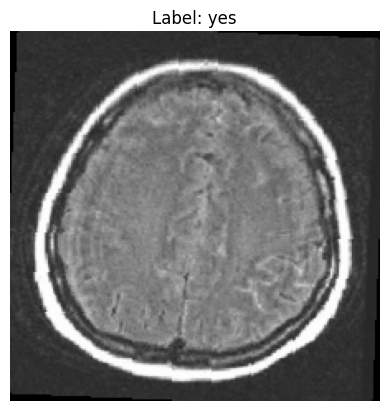

Train class distribution:
  no: 78
  yes: 124
Val class distribution:
  no: 20
  yes: 31


In [ ]:
# ---- 1) Sizes & class names
print("Total images:", len(full_ds_for_split))
print("Train images:", len(train_dataset))
print("Val images:", len(val_dataset))

class_names = train_full.classes   # ['no', 'yes']
print("Classes:", class_names)

# ---- 2) Peek at one training batch
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)   # (B, 3, 224, 224)
print("Batch labels shape:", labels.shape)
print("Unique labels in this batch:", labels.unique())



mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def imshow(img_tensor, label_idx):
    # img_tensor: (3, H, W) normalized
    img = img_tensor.detach().cpu().permute(1, 2, 0).numpy()  # (H, W, 3)
    img = (img * std + mean).clip(0, 1)                       # de-normalize
    plt.imshow(img)
    plt.title(f"Label: {class_names[int(label_idx)]}")
    plt.axis("off")
    plt.show()

imshow(images[0], labels[0].item())
# train_dataset and val_dataset are Subset objects
train_targets = np.array(train_full.targets)[train_dataset.indices]
val_targets   = np.array(train_full.targets)[val_dataset.indices]

train_counts = Counter(train_targets)
val_counts   = Counter(val_targets)

print("Train class distribution:")
for idx, cls in enumerate(class_names):
    print(f"  {cls}: {train_counts.get(idx, 0)}")

print("Val class distribution:")
for idx, cls in enumerate(class_names):
    print(f"  {cls}: {val_counts.get(idx, 0)}")

# clear data imbalance

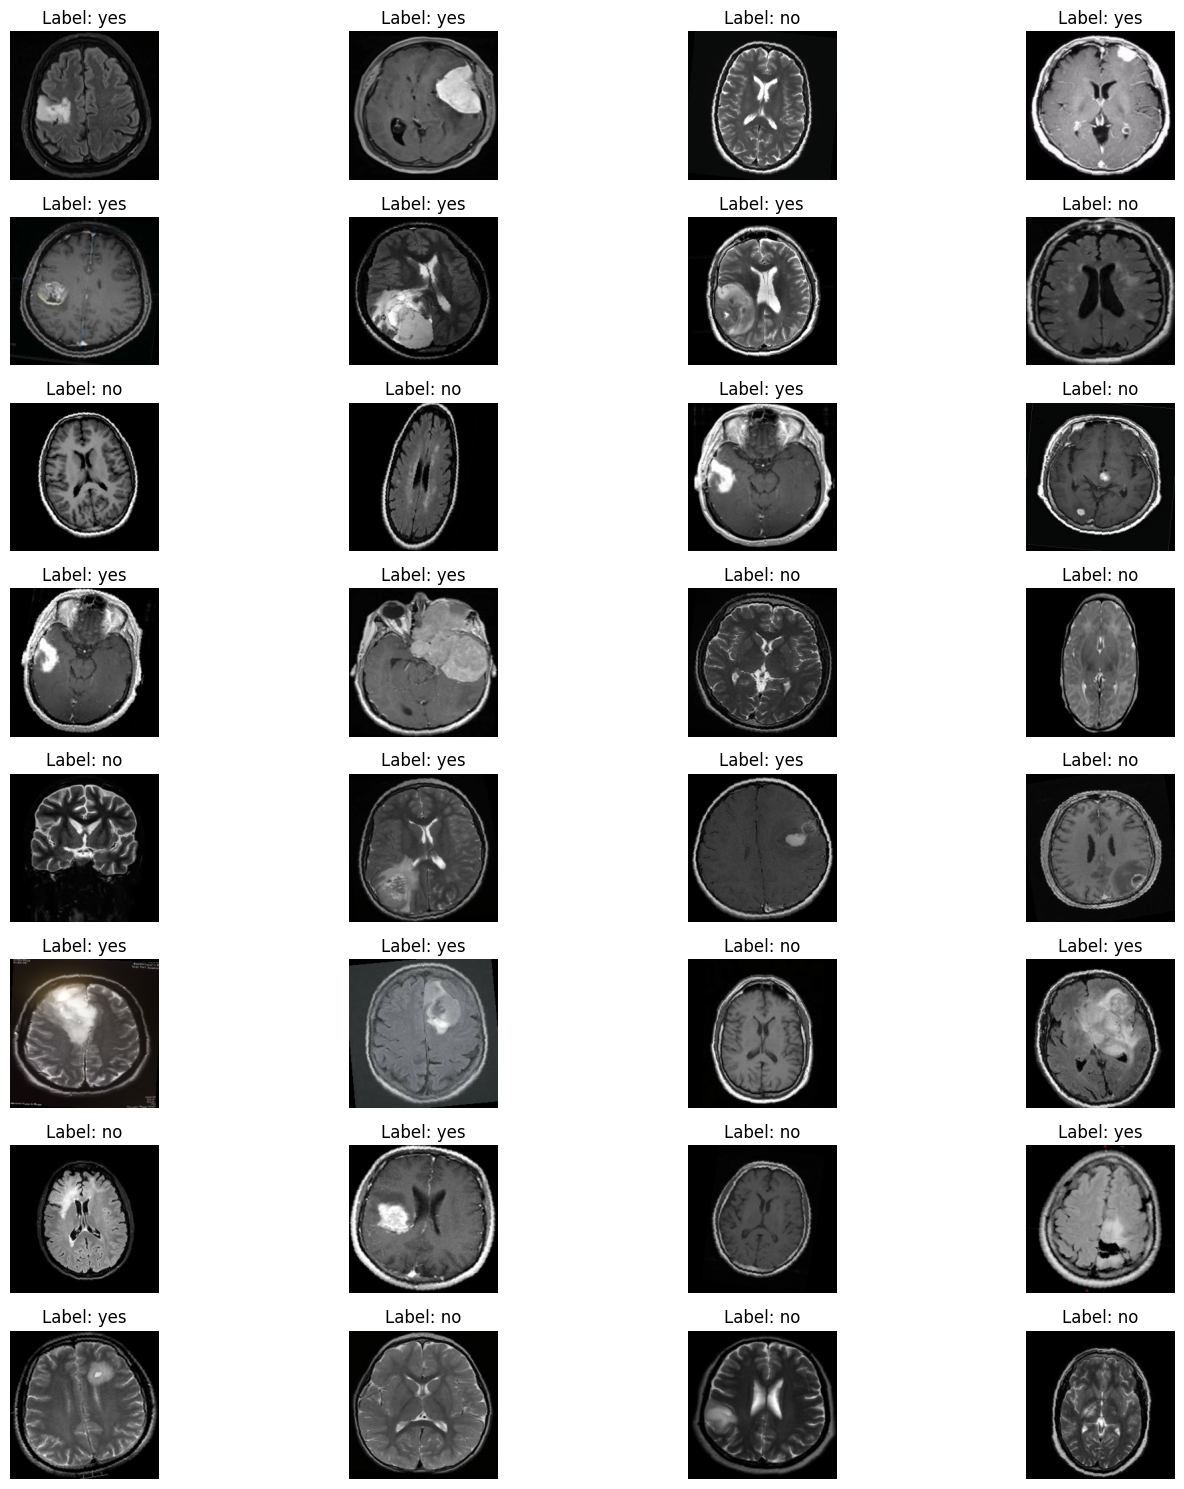

In [ ]:


# Get one batch
images, labels = next(iter(train_loader))

# Denormalize for visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images.numpy().transpose((0, 2, 3, 1))
images = (images * std + mean).clip(0, 1)

# Grid size (4 images per row)
num_images = len(images)
rows = int(np.ceil(num_images / 4))

fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f"Label: {train_dataset.dataset.classes[labels[i]]}")
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
class AnyNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        # Block 1: 3→32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (B,32,224,224)
        self.bn1   = nn.BatchNorm2d(32)
        # Block 2: 32→64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (B,64,112,112) after pool
        self.bn2   = nn.BatchNorm2d(64)
        # Block 3: 64→128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (B,128,56,56) after pool
        self.bn3   = nn.BatchNorm2d(128)

        self.pool  = nn.MaxPool2d(2)  # halves H,W

        # Head
        self.drop  = nn.Dropout(0.3)
        self.fc    = nn.Linear(128 * 28 * 28, num_classes)  # for 224x224 input

    def forward(self, x):
        # If your data is grayscale, make sure transforms convert to 3 channels
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # (B,32,112,112)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # (B,64,56,56)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # (B,128,28,28)
        x = torch.flatten(x, 1)
        x = self.drop(x)
        x = self.fc(x)                                   # (B,1) for binary
        return x

# Instantiate
model = AnyNet(num_classes=1)  # binary classification → 1 logit
model = model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, "M params")

# Loss & optimizer (binary)
pos, neg = 0, 0
for _, y in train_loader:
    y = y.view(-1)              # flatten batch
    pos += (y == 1).sum().item()
    neg += (y == 0).sum().item()

print(f"Train positives: {pos}, negatives: {neg}")

# avoid divide-by-zero if no positives
pos_weight_value = neg / max(pos, 1)
pos_weight = torch.tensor([pos_weight_value],
                          dtype=torch.float32,
                          device=device)

print(f"Using pos_weight = {pos_weight.item():.4f}")

# --- Define criterion with imbalance handling ---
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

0.194049 M params
Train positives: 124, negatives: 78
Using pos_weight = 0.6290


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # -------- TRAIN --------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).view(-1)       # (B,)
        labels = labels.view_as(outputs)       # <-- ensure (B,)

        loss = criterion(outputs, labels)      # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()

        # accumulate sample-weighted loss
        running_loss += loss.item() * labels.size(0)

        # predictions from logits
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total          # <-- per-sample avg
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # -------- VALIDATE --------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            outputs = model(inputs).view(-1)   # (B,)
            labels = labels.view_as(outputs)   # <-- ensure (B,)

            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total            # <-- per-sample avg
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), "best_model.pth")


Epoch [1/10] Train Loss: 3.2678 | Train Acc: 66.34% | Val Loss: 1.3636 | Val Acc: 68.63%
Epoch [2/10] Train Loss: 2.2874 | Train Acc: 70.79% | Val Loss: 1.0393 | Val Acc: 58.82%
Epoch [3/10] Train Loss: 1.5974 | Train Acc: 68.81% | Val Loss: 0.8031 | Val Acc: 76.47%
Epoch [4/10] Train Loss: 1.1407 | Train Acc: 75.25% | Val Loss: 1.4376 | Val Acc: 78.43%
Epoch [5/10] Train Loss: 0.7258 | Train Acc: 78.22% | Val Loss: 1.4793 | Val Acc: 80.39%
Epoch [6/10] Train Loss: 0.6296 | Train Acc: 80.69% | Val Loss: 0.7401 | Val Acc: 70.59%
Epoch [7/10] Train Loss: 0.5613 | Train Acc: 83.66% | Val Loss: 0.6724 | Val Acc: 80.39%
Epoch [8/10] Train Loss: 0.5218 | Train Acc: 84.65% | Val Loss: 1.6131 | Val Acc: 80.39%
Epoch [9/10] Train Loss: 0.7063 | Train Acc: 81.68% | Val Loss: 0.5180 | Val Acc: 86.27%
Epoch [10/10] Train Loss: 0.2643 | Train Acc: 91.58% | Val Loss: 0.5427 | Val Acc: 82.35%


              precision    recall  f1-score   support

          no       0.76      0.80      0.78        20
         yes       0.87      0.84      0.85        31

    accuracy                           0.82        51
   macro avg       0.81      0.82      0.82        51
weighted avg       0.83      0.82      0.82        51



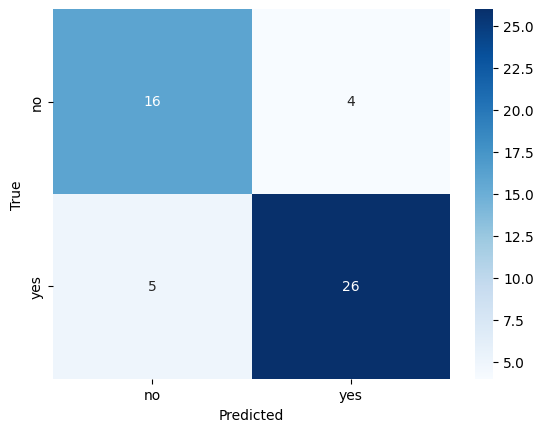

ROC-AUC: 0.924


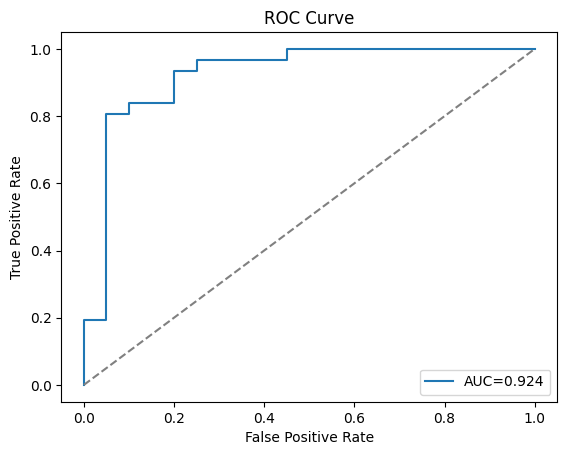

In [ ]:
# Put model in eval mode
model.eval()
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        outputs = model(inputs).view(-1)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)
        all_preds.extend(preds)

# ---- 1. Classification report ----
print(classification_report(all_labels, all_preds, target_names=['no', 'yes']))

# ---- 2. Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no','yes'], yticklabels=['no','yes'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---- 3. ROC-AUC ----
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"ROC-AUC: {roc_auc:.3f}")

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
class AnyNet2(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(2)

        # head: GAP + GMP
        self.gap   = nn.AdaptiveAvgPool2d(1)
        self.gmp   = nn.AdaptiveMaxPool2d(1)
        self.drop  = nn.Dropout(0.3)
        self.fc    = nn.Linear(128 * 2, num_classes)   # 256 → 1

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        a = self.gap(x).flatten(1)   # (B,128)
        m = self.gmp(x).flatten(1)   # (B,128)
        x = torch.cat([a, m], dim=1) # (B,256)
        x = self.drop(x)
        return self.fc(x)


model2 = AnyNet2(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=3e-4, weight_decay=1e-4)


In [ ]:
# --- Tracking ---
num_epochs = 10
best_val_accuracy = 0.0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # -------- TRAIN --------
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)          # may be (B,) or (B,1)

        optimizer.zero_grad(set_to_none=True)
        outputs = model2(inputs).view(-1)           # (B,) logits
        labels = labels.view_as(outputs)            # <-- ensure same shape

        loss = criterion(outputs, labels)           # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)  # <-- per-sample sum

        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total               # <-- average per sample
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # -------- VALIDATE --------
    model2.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            outputs = model2(inputs).view(-1)       # (B,)
            labels = labels.view_as(outputs)        # <-- ensure same shape

            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total                 # <-- average per sample
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    # Save best by validation accuracy
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model2.state_dict(), "best_model2.pth")


Epoch [1/10] Train Loss: 1.0517 | Train Acc: 49.50% | Val Loss: 0.7287 | Val Acc: 39.22%
Epoch [2/10] Train Loss: 0.9137 | Train Acc: 49.50% | Val Loss: 0.6977 | Val Acc: 45.10%
Epoch [3/10] Train Loss: 0.7488 | Train Acc: 66.83% | Val Loss: 0.6379 | Val Acc: 66.67%
Epoch [4/10] Train Loss: 0.6893 | Train Acc: 70.30% | Val Loss: 0.5955 | Val Acc: 74.51%
Epoch [5/10] Train Loss: 0.6661 | Train Acc: 65.35% | Val Loss: 0.5595 | Val Acc: 76.47%
Epoch [6/10] Train Loss: 0.6518 | Train Acc: 67.82% | Val Loss: 0.5267 | Val Acc: 76.47%
Epoch [7/10] Train Loss: 0.6495 | Train Acc: 67.33% | Val Loss: 0.5205 | Val Acc: 74.51%
Epoch [8/10] Train Loss: 0.5870 | Train Acc: 70.30% | Val Loss: 0.4972 | Val Acc: 78.43%
Epoch [9/10] Train Loss: 0.5593 | Train Acc: 73.27% | Val Loss: 0.5083 | Val Acc: 74.51%
Epoch [10/10] Train Loss: 0.5965 | Train Acc: 66.83% | Val Loss: 0.4851 | Val Acc: 76.47%


              precision    recall  f1-score   support

          no       0.79      0.55      0.65        20
         yes       0.76      0.90      0.82        31

    accuracy                           0.76        51
   macro avg       0.77      0.73      0.74        51
weighted avg       0.77      0.76      0.75        51



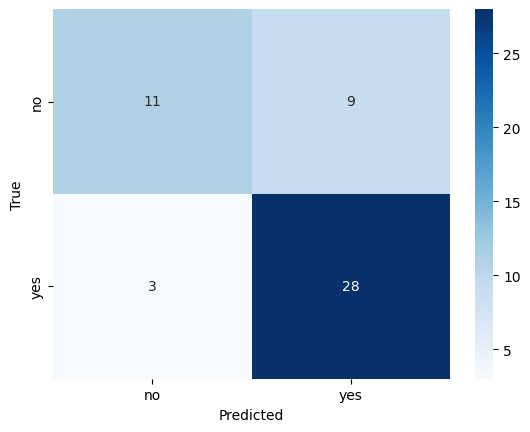

ROC-AUC: 0.865


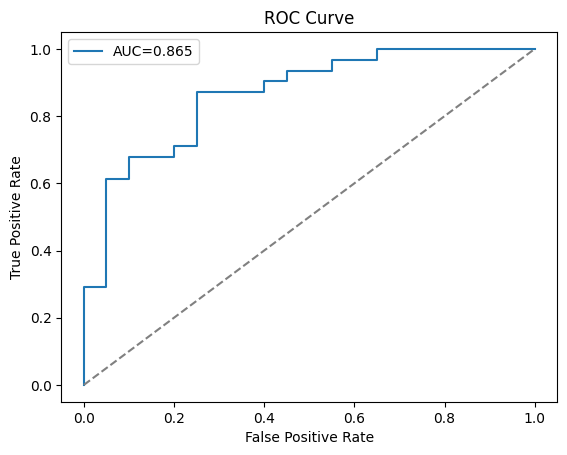

In [ ]:
# Put model in eval mode
model2.eval()
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        outputs = model2(inputs).view(-1)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)
        all_preds.extend(preds)

# ---- 1. Classification report ----
print(classification_report(all_labels, all_preds, target_names=['no', 'yes']))

# ---- 2. Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no','yes'], yticklabels=['no','yes'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---- 3. ROC-AUC ----
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"ROC-AUC: {roc_auc:.3f}")

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# we can clearly see an underfitting atittude

In [ ]:
class AnyNet3(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        # conv blocks
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(2)

        # mini-spatial head (7×7)
        self.avg7  = nn.AdaptiveAvgPool2d((7, 7))    # -> (B,128,7,7)
        self.drop  = nn.Dropout(0.2)
        self.head  = nn.Sequential(
            nn.Flatten(),                            # (B,6272)
            nn.Linear(128*7*7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)              # -> (B,1)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.avg7(x)
        x = self.drop(x)
        return self.head(x)

model3 = AnyNet3(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model3.parameters(), lr=3e-4, weight_decay=1e-4)



In [ ]:
# --- Tracking ---
num_epochs = 10
best_val_accuracy = 0.0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # -------- TRAIN --------
    model3.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)          # may be (B,) or (B,1)

        optimizer.zero_grad(set_to_none=True)
        outputs = model3(inputs).view(-1)           # (B,) logits
        labels = labels.view_as(outputs)            # <-- ensure same shape

        loss = criterion(outputs, labels)           # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)  # per-sample sum

        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total               # average per sample
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # -------- VALIDATE --------
    model3.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            outputs = model3(inputs).view(-1)       # (B,) logits
            labels = labels.view_as(outputs)        # <-- ensure same shape

            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total                 # average per sample
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    # Save best by validation accuracy (save model3!)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model3.state_dict(), "best_model3.pth")


Epoch [1/10] Train Loss: 0.7154 | Train Acc: 60.89% | Val Loss: 0.6708 | Val Acc: 66.67%
Epoch [2/10] Train Loss: 0.5417 | Train Acc: 78.71% | Val Loss: 0.6140 | Val Acc: 72.55%
Epoch [3/10] Train Loss: 0.5038 | Train Acc: 78.71% | Val Loss: 0.5922 | Val Acc: 74.51%
Epoch [4/10] Train Loss: 0.5192 | Train Acc: 79.21% | Val Loss: 0.5416 | Val Acc: 68.63%
Epoch [5/10] Train Loss: 0.4810 | Train Acc: 78.22% | Val Loss: 0.5080 | Val Acc: 78.43%
Epoch [6/10] Train Loss: 0.4672 | Train Acc: 78.71% | Val Loss: 0.4851 | Val Acc: 74.51%
Epoch [7/10] Train Loss: 0.4483 | Train Acc: 80.20% | Val Loss: 0.4723 | Val Acc: 76.47%
Epoch [8/10] Train Loss: 0.4299 | Train Acc: 80.20% | Val Loss: 0.4878 | Val Acc: 74.51%
Epoch [9/10] Train Loss: 0.4216 | Train Acc: 81.68% | Val Loss: 0.4502 | Val Acc: 78.43%
Epoch [10/10] Train Loss: 0.4159 | Train Acc: 81.68% | Val Loss: 0.4851 | Val Acc: 74.51%


              precision    recall  f1-score   support

          no       0.73      0.55      0.63        20
         yes       0.75      0.87      0.81        31

    accuracy                           0.75        51
   macro avg       0.74      0.71      0.72        51
weighted avg       0.74      0.75      0.74        51



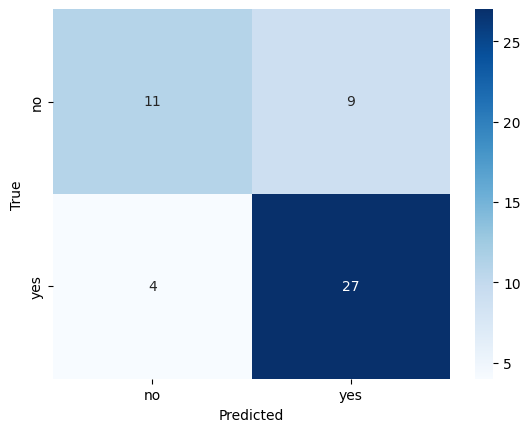

ROC-AUC: 0.847


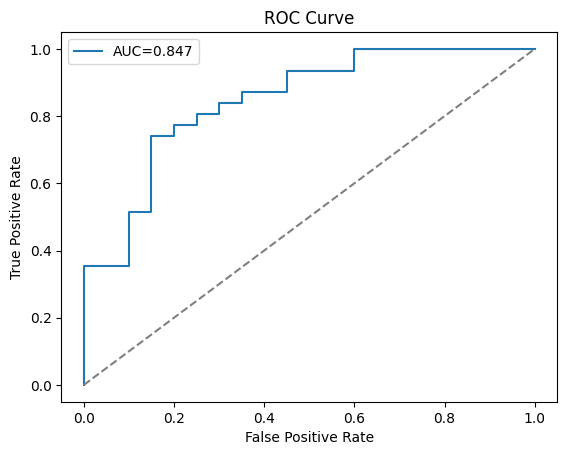

In [ ]:
# Put model in eval mode
model3.eval()
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        outputs = model3(inputs).view(-1)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)
        all_preds.extend(preds)

# ---- 1. Classification report ----
print(classification_report(all_labels, all_preds, target_names=['no', 'yes']))

# ---- 2. Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no','yes'], yticklabels=['no','yes'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---- 3. ROC-AUC ----
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"ROC-AUC: {roc_auc:.3f}")

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
class AnyNet4(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        # conv blocks
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(2)  # 224→112→56→28 after 3 pools

        # mini-spatial head (10×10)
        self.avg10 = nn.AdaptiveAvgPool2d((10, 10))      # -> (B,128,10,10)
        self.drop  = nn.Dropout(0.2)
        self.head  = nn.Sequential(
            nn.Flatten(),                                 # (B, 128*10*10 = 12,800)
            nn.Linear(128*10*10, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)                  # -> (B,1)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.avg10(x)
        x = self.drop(x)
        return self.head(x)

model4 = AnyNet4(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model4.parameters(), lr=3e-4, weight_decay=1e-4)


In [ ]:
# --- Tracking ---
num_epochs = 10
best_val_accuracy = 0.0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # -------- TRAIN --------
    model4.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)           # may be (B,) or (B,1)

        optimizer.zero_grad(set_to_none=True)
        outputs = model4(inputs).view(-1)            # (B,) logits
        labels = labels.view_as(outputs)             # <-- ensure SAME shape

        loss = criterion(outputs, labels)            # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0) # sample-weighted sum

        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total                # per-sample average
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # -------- VALIDATE --------
    model4.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            outputs = model4(inputs).view(-1)        # <-- use model4
            labels = labels.view_as(outputs)         # <-- ensure SAME shape

            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total                  # per-sample average
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    # save best by validation accuracy (save model4)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model4.state_dict(), "best_model4.pth")


Epoch [1/10] Train Loss: 1.0754 | Train Acc: 57.43% | Val Loss: 0.6691 | Val Acc: 66.67%
Epoch [2/10] Train Loss: 0.6041 | Train Acc: 71.78% | Val Loss: 0.6094 | Val Acc: 68.63%
Epoch [3/10] Train Loss: 0.5770 | Train Acc: 72.77% | Val Loss: 0.6109 | Val Acc: 66.67%
Epoch [4/10] Train Loss: 0.5053 | Train Acc: 77.23% | Val Loss: 0.5523 | Val Acc: 74.51%
Epoch [5/10] Train Loss: 0.4921 | Train Acc: 77.72% | Val Loss: 0.5262 | Val Acc: 74.51%
Epoch [6/10] Train Loss: 0.4658 | Train Acc: 81.19% | Val Loss: 0.5178 | Val Acc: 76.47%
Epoch [7/10] Train Loss: 0.4562 | Train Acc: 81.68% | Val Loss: 0.5233 | Val Acc: 72.55%
Epoch [8/10] Train Loss: 0.4497 | Train Acc: 79.70% | Val Loss: 0.5046 | Val Acc: 74.51%
Epoch [9/10] Train Loss: 0.4359 | Train Acc: 80.69% | Val Loss: 0.4911 | Val Acc: 76.47%
Epoch [10/10] Train Loss: 0.4281 | Train Acc: 82.18% | Val Loss: 0.5038 | Val Acc: 74.51%


              precision    recall  f1-score   support

          no       0.73      0.55      0.63        20
         yes       0.75      0.87      0.81        31

    accuracy                           0.75        51
   macro avg       0.74      0.71      0.72        51
weighted avg       0.74      0.75      0.74        51



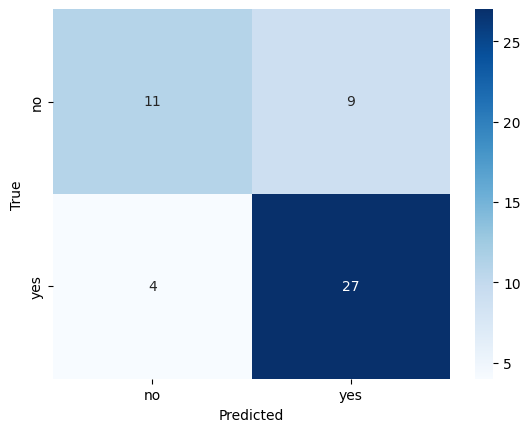

ROC-AUC: 0.834


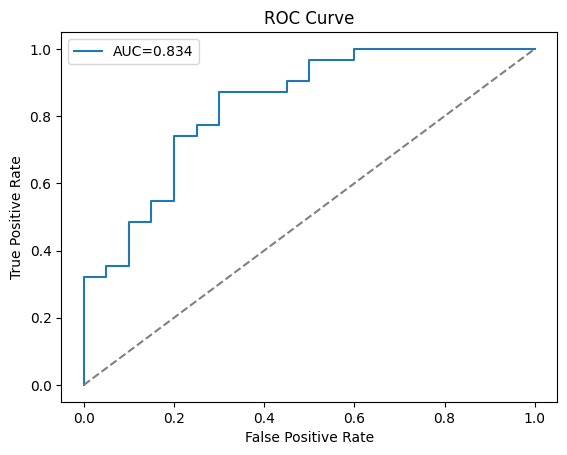

In [ ]:
# Put model in eval mode
model4.eval()
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        outputs = model4(inputs).view(-1)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)
        all_preds.extend(preds)

# ---- 1. Classification report ----
print(classification_report(all_labels, all_preds, target_names=['no', 'yes']))

# ---- 2. Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no','yes'], yticklabels=['no','yes'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---- 3. ROC-AUC ----
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"ROC-AUC: {roc_auc:.3f}")

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# following this results we use anynet as a beseline
# The first improvment we'll do is use BCE with pos_weight to handle class imbalance meaning the errors in the majority class  will cost less
# Secondly were gonna increase the size of the input's

In [ ]:
# === 256x256 transforms (new variable names) ===
train_tfms_256 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_tfms_256 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# --- Build parallel datasets/loaders using the SAME indices ---
# (reuses full_ds_for_split, train_idx, val_idx, SEED from earlier)
train_full_256 = datasets.ImageFolder("/content/data/brain_tumor_dataset", transform=train_tfms_256)
val_full_256   = datasets.ImageFolder("/content/data/brain_tumor_dataset", transform=val_tfms_256)

train_dataset_256 = Subset(train_full_256, train_idx)
val_dataset_256   = Subset(val_full_256,   val_idx)

train_loader_256 = DataLoader(train_dataset_256, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=True)
val_loader_256   = DataLoader(val_dataset_256,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=True)

print("Train_256 images:", len(train_dataset_256))
print("Val_256 images:",   len(val_dataset_256))


Train_256 images: 202
Val_256 images: 51


In [ ]:
# ==== Sanity check: ensure 256x256 pipeline is used ====
model_256.eval()

xb_256, yb_256 = next(iter(val_loader_256))
print("Val_256 batch shape:", xb_256.shape)  # should be (B, 3, 256, 256)

# If this doesn't show 256 height/width, re-check val_tfms_256 / val_loader_256


Val_256 batch shape: torch.Size([32, 3, 256, 256])


In [ ]:
# === AnyNet variant for 256x256 inputs ===
class AnyNet256(nn.Module):
    def __init__(self, num_classes=1, dropout=0.3):
        super().__init__()
        # Blocks
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (B,32,256,256)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (B,64,128,128) after pool
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (B,128,64,64) after pool
        self.bn3   = nn.BatchNorm2d(128)

        self.pool  = nn.MaxPool2d(2)  # halves H,W each time

        # Head (flatten, size-specific for 256x256 → 128×32×32)
        self.drop  = nn.Dropout(dropout)
        self.fc    = nn.Linear(128 * 32 * 32, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # (B,32,128,128)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # (B,64,64,64)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # (B,128,32,32)
        x = torch.flatten(x, 1)
        x = self.drop(x)
        return self.fc(x)  # logits (B,1)


In [ ]:
# === Class imbalance handling for 256 pipeline ===
pos_256 = neg_256 = 0
for _, y in train_loader_256:
    y = y.view(-1)
    pos_256 += (y == 1).sum().item()
    neg_256 += (y == 0).sum().item()

print(f"[256] Train positives: {pos_256}, negatives: {neg_256}")

pos_weight_value_256 = neg_256 / max(pos_256, 1)
pos_weight_256 = torch.tensor([pos_weight_value_256], dtype=torch.float32, device=device)
print(f"[256] Using pos_weight = {pos_weight_256.item():.4f}")

criterion_256 = nn.BCEWithLogitsLoss(pos_weight=pos_weight_256)


[256] Train positives: 124, negatives: 78
[256] Using pos_weight = 0.6290


In [ ]:
model_256 = AnyNet256(num_classes=1, dropout=0.3).to(device)
print("AnyNet256 params (M):", sum(p.numel() for p in model_256.parameters())/1e6)

optimizer_256 = torch.optim.AdamW(model_256.parameters(), lr=1e-3, weight_decay=1e-4)


AnyNet256 params (M): 0.224769


In [ ]:
# --- Tracking (256 run) ---
num_epochs_256 = 10
best_val_accuracy_256 = 0.0

train_losses_256, val_losses_256 = [], []
train_accuracies_256, val_accuracies_256 = [], []

for epoch in range(num_epochs_256):
    # -------- TRAIN --------
    model_256.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader_256:
        inputs = inputs.to(device)
        labels = labels.float().to(device)             # may be (B,) or (B,1)

        optimizer_256.zero_grad(set_to_none=True)
        outputs = model_256(inputs).view(-1)           # (B,) logits
        labels = labels.view_as(outputs)               # ensure SAME shape

        loss = criterion_256(outputs, labels)          # BCEWithLogitsLoss (weighted)
        loss.backward()
        optimizer_256.step()

        running_loss += loss.item() * labels.size(0)   # per-sample sum

        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total                  # average per sample
    train_acc = correct / total
    train_losses_256.append(train_loss)
    train_accuracies_256.append(train_acc)

    # -------- VALIDATE --------
    model_256.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader_256:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            outputs = model_256(inputs).view(-1)       # (B,) logits
            labels = labels.view_as(outputs)           # ensure SAME shape

            loss = criterion_256(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total                    # average per sample
    val_acc = correct / total
    val_losses_256.append(val_loss)
    val_accuracies_256.append(val_acc)

    print(f"[256] Epoch [{epoch+1}/{num_epochs_256}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    # Save best by validation accuracy
    if val_acc > best_val_accuracy_256:
        best_val_accuracy_256 = val_acc
        torch.save(model_256.state_dict(), "best_model256.pth")


[256] Epoch [1/10] Train Loss: 0.3177 | Train Acc: 90.10% | Val Loss: 1.9243 | Val Acc: 74.51%
[256] Epoch [2/10] Train Loss: 0.6042 | Train Acc: 83.66% | Val Loss: 1.5380 | Val Acc: 86.27%
[256] Epoch [3/10] Train Loss: 0.5183 | Train Acc: 89.11% | Val Loss: 0.6951 | Val Acc: 90.20%
[256] Epoch [4/10] Train Loss: 0.0924 | Train Acc: 95.54% | Val Loss: 0.4179 | Val Acc: 88.24%
[256] Epoch [5/10] Train Loss: 0.2073 | Train Acc: 93.56% | Val Loss: 0.3900 | Val Acc: 82.35%
[256] Epoch [6/10] Train Loss: 0.2466 | Train Acc: 92.08% | Val Loss: 0.8616 | Val Acc: 90.20%
[256] Epoch [7/10] Train Loss: 0.2042 | Train Acc: 93.07% | Val Loss: 0.6570 | Val Acc: 84.31%
[256] Epoch [8/10] Train Loss: 0.0541 | Train Acc: 97.52% | Val Loss: 0.7033 | Val Acc: 80.39%
[256] Epoch [9/10] Train Loss: 0.2620 | Train Acc: 92.57% | Val Loss: 1.4637 | Val Acc: 86.27%
[256] Epoch [10/10] Train Loss: 0.2684 | Train Acc: 90.59% | Val Loss: 0.9822 | Val Acc: 84.31%


Val_256 batch shape: torch.Size([32, 3, 256, 256])


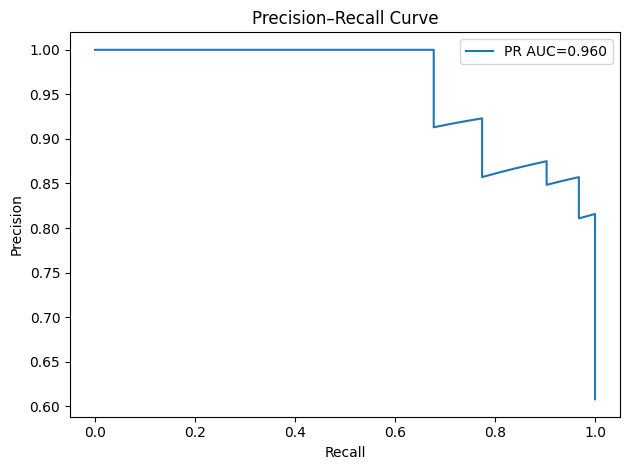

[256] Best threshold=0.282 | F1=0.909 | Precision=0.857 | Recall=0.968
              precision    recall  f1-score   support

          no       0.94      0.75      0.83        20
         yes       0.86      0.97      0.91        31

    accuracy                           0.88        51
   macro avg       0.90      0.86      0.87        51
weighted avg       0.89      0.88      0.88        51



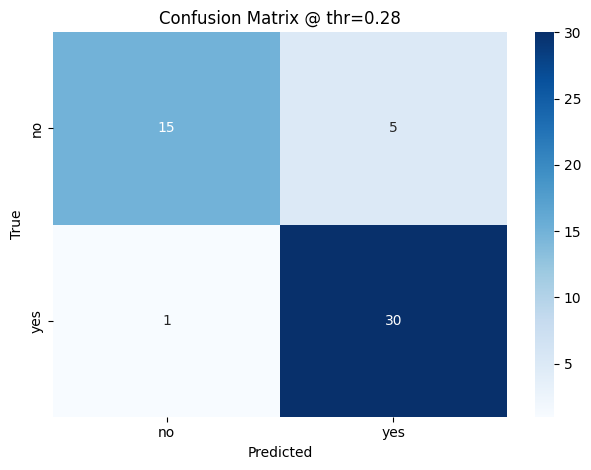

ROC AUC: 0.937


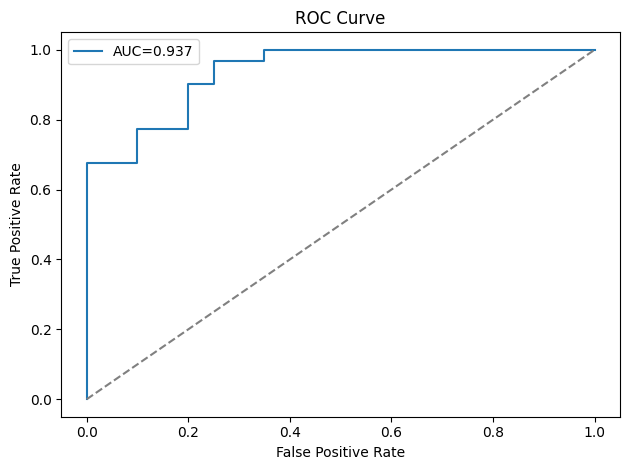

Saved figures into ./figs/ with timestamp 20250926_131053


In [ ]:
# Make sure figs/ exists
os.makedirs("figs", exist_ok=True)
timestamp = time.strftime("%Y%m%d_%H%M%S")

# --- Sanity check ---
xb_256, yb_256 = next(iter(val_loader_256))
print("Val_256 batch shape:", xb_256.shape)  # should be (B, 3, 256, 256)

model_256.eval()
all_labels, all_probs = [], []

with torch.no_grad():
    for inputs, labels in val_loader_256:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        logits = model_256(inputs).view(-1)
        probs  = torch.sigmoid(logits).cpu().numpy()

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)

all_labels = np.array(all_labels, dtype=np.float32)
all_probs  = np.array(all_probs,  dtype=np.float32)

# ---- PR AUC & PR curve ----
pr_auc = average_precision_score(all_labels, all_probs)
prec, rec, thr = precision_recall_curve(all_labels, all_probs)

plt.figure()
plt.plot(rec, prec, label=f"PR AUC={pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve")
plt.legend(); plt.tight_layout()
plt.savefig(f"figs/pr_curve_{timestamp}.png", dpi=200)
plt.show()

# ---- Threshold sweep (maximize F1) ----
f1_scores = 2 * prec * rec / (prec + rec + 1e-8)
best_idx  = int(np.nanargmax(f1_scores))
best_thr  = float(thr[best_idx]) if best_idx < len(thr) else 0.5

print(f"[256] Best threshold={best_thr:.3f} | F1={f1_scores[best_idx]:.3f} | "
      f"Precision={prec[best_idx]:.3f} | Recall={rec[best_idx]:.3f}")

# ---- Apply best threshold & full report ----
final_preds = (all_probs >= best_thr).astype(int)

print(classification_report(all_labels, final_preds, target_names=['no','yes']))

cm = confusion_matrix(all_labels, final_preds)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no','yes'], yticklabels=['no','yes'])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title(f"Confusion Matrix @ thr={best_thr:.2f}")
plt.tight_layout()
plt.savefig(f"figs/confmat_{timestamp}.png", dpi=200)
plt.show()

# ---- ROC AUC & ROC curve ----
roc_auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
print(f"ROC AUC: {roc_auc:.3f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend()
plt.tight_layout()
plt.savefig(f"figs/roc_curve_{timestamp}.png", dpi=200)
plt.show()

# Save the chosen threshold for later (test-time reuse)
BEST_THR_256 = best_thr
print(f"Saved figures into ./figs/ with timestamp {timestamp}")

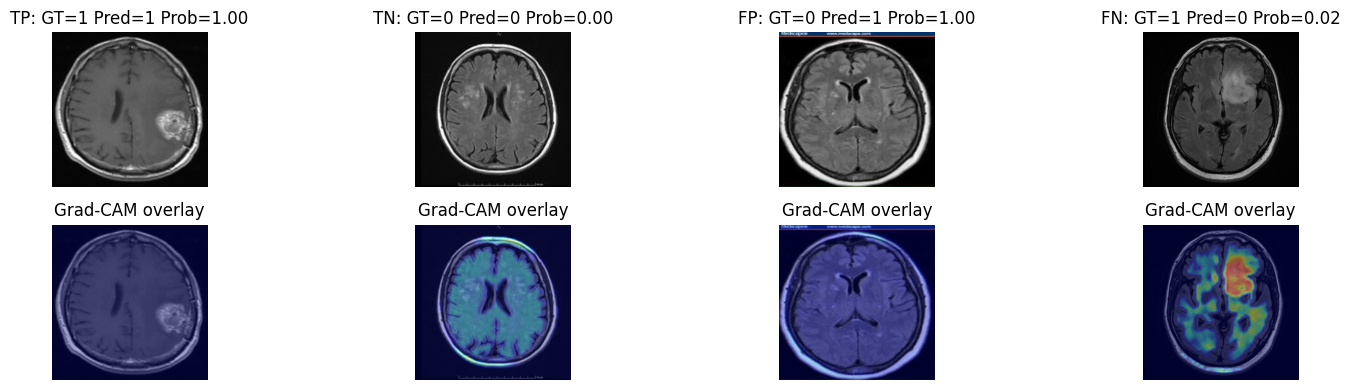

Saved Grad-CAM gallery to: figs_256/gradcam_gallery_20250926_125332.png
Threshold used: 0.282 | Counts -> TP:30 TN:15 FP:5 FN:1


In [ ]:

# ----- config -----
IMG_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMG_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
LAYER_NAME = "conv3"     # last conv layer in AnyNet256
N_SHOW = 4               # how many examples to show in the grid (max 4: TP,TN,FP,FN)

# ----- helpers -----
def denorm(img_t):
    # img_t: (3,H,W) tensor on CPU
    img = img_t.permute(1,2,0).numpy()
    img = (img * IMG_STD + IMG_MEAN).clip(0,1)
    return img

def make_overlay(img_rgb, cam, alpha=0.35):
    # img_rgb: (H,W,3) in [0,1], cam: (H,W) in [0,1]
    cmap = plt.get_cmap("jet")
    heat = cmap(cam)[:, :, :3]          # drop alpha
    return (1 - alpha) * img_rgb + alpha * heat

class GradCAM:
    def __init__(self, model, layer_attr="conv3"):
        self.model = model
        self.layer = getattr(model, layer_attr)
        self.activations = None
        self.gradients = None
        self.h_act = self.layer.register_forward_hook(self._save_activation)
        self.h_grad = self.layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out.detach()

    def _save_gradient(self, module, grad_in, grad_out):
        # grad_out is a tuple; take the grads w.r.t. outputs
        self.gradients = grad_out[0].detach()

    def __call__(self, logits, retain_graph=False):
        # logits: (B,) raw logits AFTER forward; backprop w.r.t. positive class logit
        self.model.zero_grad(set_to_none=True)
        loss = logits.sigmoid().sum()   # d(prob)/d(acts); good signal for positive class
        loss.backward(retain_graph=retain_graph)
        A = self.activations            # (B,C,H,W)
        G = self.gradients              # (B,C,H,W)
        weights = G.mean(dim=(2,3), keepdim=True)      # GAP over spatial: (B,C,1,1)
        cam = (weights * A).sum(dim=1)                 # (B,H,W)
        cam = torch.relu(cam)
        # normalize per-sample to [0,1]
        cam_min = cam.view(cam.size(0), -1).min(dim=1)[0].view(-1,1,1)
        cam_max = cam.view(cam.size(0), -1).max(dim=1)[0].view(-1,1,1)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
        return cam

    def close(self):
        self.h_act.remove()
        self.h_grad.remove()

# ----- collect predictions on val (256) -----
model_256.eval()
all_imgs, all_labels, all_probs, all_logits = [], [], [], []

with torch.no_grad():
    for xb, yb in val_loader_256:
        xb = xb.to(device)
        yb = yb.float().to(device)
        logits = model_256(xb).view(-1)
        probs  = torch.sigmoid(logits)

        all_imgs.append(xb.cpu())
        all_labels.append(yb.cpu())
        all_probs.append(probs.cpu())
        all_logits.append(logits.cpu())

all_imgs   = torch.cat(all_imgs,   dim=0)    # (N,3,H,W) on CPU
all_labels = torch.cat(all_labels, dim=0).numpy().astype(int)   # (N,)
all_probs  = torch.cat(all_probs,  dim=0).numpy()               # (N,)
all_logits = torch.cat(all_logits, dim=0)                       # (N,)

# threshold: use BEST_THR_256 if available, else F1-optimal
if "BEST_THR_256" in globals():
    thr = float(BEST_THR_256)
else:
    prec, rec, thr_arr = precision_recall_curve(all_labels, all_probs)
    f1 = 2*prec*rec/(prec+rec+1e-8)
    best_idx = int(np.nanargmax(f1))
    thr = float(thr_arr[best_idx]) if best_idx < len(thr_arr) else 0.5

preds = (all_probs >= thr).astype(int)

# ----- find TP / TN / FP / FN indices -----
labels_np = all_labels
TP_idx = np.where((preds==1) & (labels_np==1))[0]
TN_idx = np.where((preds==0) & (labels_np==0))[0]
FP_idx = np.where((preds==1) & (labels_np==0))[0]
FN_idx = np.where((preds==0) & (labels_np==1))[0]

buckets = [
    ("TP", TP_idx),
    ("TN", TN_idx),
    ("FP", FP_idx),
    ("FN", FN_idx),
]

# pick one example per bucket (or skip if empty)
examples = []
for name, idxs in buckets:
    if len(idxs) > 0:
        examples.append((name, int(idxs[0])))
if len(examples) == 0:
    print("No examples to display (threshold may be extreme).")
else:
    # ----- compute Grad-CAM for selected samples -----
    cam_engine = GradCAM(model_256, layer_attr=LAYER_NAME)
    # We need grads, so run forward again on just the selected samples (with requires_grad)
    sel_tensors = []
    for _, i in examples:
        sel_tensors.append(all_imgs[i].unsqueeze(0))  # (1,3,H,W)
    xb_sel = torch.cat(sel_tensors, dim=0).to(device) # (K,3,H,W)
    xb_sel.requires_grad_(True)

    logits_sel = model_256(xb_sel).view(-1)          # (K,)
    cams = cam_engine(logits_sel, retain_graph=False).cpu().numpy()  # (K,H',W')
    cam_engine.close()

    # ----- plot grid -----
    K = len(examples)
    cols = K
    plt.figure(figsize=(4*cols, 4))
    for j, (name, idx) in enumerate(examples, start=1):
        img_rgb = denorm(all_imgs[idx])               # (H,W,3)
        cam = cams[j-1]
        # resize cam to image size if needed
        if cam.shape[:2] != img_rgb.shape[:2]:
            from skimage.transform import resize as rz
            cam = rz(cam, img_rgb.shape[:2], order=1, preserve_range=True, anti_aliasing=True)
            cam = np.clip(cam, 0, 1)

        overlay = make_overlay(img_rgb, cam, alpha=0.35)

        plt.subplot(2, cols, j)
        plt.imshow(img_rgb); plt.axis("off")
        plt.title(f"{name}: GT={labels_np[idx]} Pred={preds[idx]} Prob={all_probs[idx]:.2f}")

        plt.subplot(2, cols, j+cols)
        plt.imshow(overlay); plt.axis("off")
        plt.title("Grad-CAM overlay")
    plt.tight_layout()

    os.makedirs("figs_256", exist_ok=True)
    stamp = time.strftime("%Y%m%d_%H%M%S")
    out_path = f"figs_256/gradcam_gallery_{stamp}.png"
    plt.savefig(out_path, dpi=200)
    plt.show()

    print(f"Saved Grad-CAM gallery to: {out_path}")
    print(f"Threshold used: {thr:.3f} | Counts -> TP:{len(TP_idx)} TN:{len(TN_idx)} FP:{len(FP_idx)} FN:{len(FN_idx)}")
